In [40]:
import numpy as np
import pandas as pd
import neptune
import os
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm.notebook import tqdm

gpu_session = True
cpu_session = False
gpus = cpus = []
if gpu_session:
    gpus = tf.config.experimental.list_physical_devices('GPU')
if cpu_session:
    cpus = tf.config.experimental.list_physical_devices('CPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[0], True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
if cpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(cpus[0], 'CPU')
    tf.config.experimental.set_visible_devices([], 'GPU')
    logical_cpus = tf.config.experimental.list_logical_devices('CPU')
    print(len(cpus), "Physical CPUs,", len(logical_cpus), "Logical CPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [41]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [42]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if this is longer then the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [43]:
timesteps = 1


d1_col = 6              # First day column
n_days = 1911            # Number of days to analyse

filename = '../data/'   # Data directory

state = ''            # Data subdivision to analyse, leave blank study entire dataset

if state:
    filename += '%s/%s_data.csv' % (state, state)
else:
    filename += 'sales_train_validation.csv'

sales = pd.read_csv(filename)                 # Read data
calendar = pd.read_csv("../data/calendar.csv")
selling_prices = pd.read_csv("../data/sell_prices.csv")
sample_submission = pd.read_csv("../data/sample_submission.csv")

In [44]:
from sklearn.preprocessing import OrdinalEncoder

def prep_calendar(df):
    df = df.drop(["date", "weekday"], axis=1)
    df = df.assign(d = df.d.str[2:].astype(int))
    df = df.fillna("missing")
    cols = list(set(df.columns) - {"wm_yr_wk", "d"})
    df[cols] = OrdinalEncoder(dtype="int").fit_transform(df[cols])
    df = reduce_mem_usage(df)
    return df

print(calendar.head)
calendar = prep_calendar(calendar)
print(calendar.head)


<bound method NDFrame.head of             date  wm_yr_wk    weekday  wday  month  year       d  \
0     2011-01-29     11101   Saturday     1      1  2011     d_1   
1     2011-01-30     11101     Sunday     2      1  2011     d_2   
2     2011-01-31     11101     Monday     3      1  2011     d_3   
3     2011-02-01     11101    Tuesday     4      2  2011     d_4   
4     2011-02-02     11101  Wednesday     5      2  2011     d_5   
...          ...       ...        ...   ...    ...   ...     ...   
1964  2016-06-15     11620  Wednesday     5      6  2016  d_1965   
1965  2016-06-16     11620   Thursday     6      6  2016  d_1966   
1966  2016-06-17     11620     Friday     7      6  2016  d_1967   
1967  2016-06-18     11621   Saturday     1      6  2016  d_1968   
1968  2016-06-19     11621     Sunday     2      6  2016  d_1969   

      event_name_1 event_type_1  event_name_2 event_type_2  snap_CA  snap_TX  \
0              NaN          NaN           NaN          NaN        0      

In [45]:
def prep_selling_prices(df):
    gr = df.groupby(["store_id", "item_id"])["sell_price"]
    df["sell_price_rel_diff"] = gr.pct_change()
    df["sell_price_roll_sd7"] = gr.transform(lambda x: x.rolling(7).std())
    df["sell_price_cumrel"] = (gr.shift(0) - gr.cummin()) / (1 + gr.cummax() - gr.cummin())
    df = reduce_mem_usage(df)
    return df

print(selling_prices.head)
selling_prices = prep_selling_prices(selling_prices)
print(selling_prices.head)

<bound method NDFrame.head of         store_id        item_id  wm_yr_wk  sell_price
0           CA_1  HOBBIES_1_001     11325        9.58
1           CA_1  HOBBIES_1_001     11326        9.58
2           CA_1  HOBBIES_1_001     11327        8.26
3           CA_1  HOBBIES_1_001     11328        8.26
4           CA_1  HOBBIES_1_001     11329        8.26
...          ...            ...       ...         ...
6841116     WI_3    FOODS_3_827     11617        1.00
6841117     WI_3    FOODS_3_827     11618        1.00
6841118     WI_3    FOODS_3_827     11619        1.00
6841119     WI_3    FOODS_3_827     11620        1.00
6841120     WI_3    FOODS_3_827     11621        1.00

[6841121 rows x 4 columns]>
Mem. usage decreased to 169.63 Mb (53.6% reduction)
<bound method NDFrame.head of         store_id        item_id  wm_yr_wk  sell_price  sell_price_rel_diff  \
0           CA_1  HOBBIES_1_001     11325    9.578125                  NaN   
1           CA_1  HOBBIES_1_001     11326    9.578125  

In [46]:
def reshape_sales(df, drop_d = None):
    if drop_d is not None:
        df = df.drop(["d_" + str(i + 1) for i in range(drop_d)], axis=1)
    df = df.assign(id=df.id.str.replace("_validation", ""))
    df = df.reindex(columns=df.columns.tolist() + ["d_" + str(1913 + i + 1) for i in range(2 * 28)])
    df = df.melt(id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
                 var_name='d', value_name='demand')
    df = df.assign(d=df.d.str[2:].astype("int16"))
    return df

print(sales.head)
sales = reshape_sales(sales, 1000)
print(sales.head)

<bound method NDFrame.head of                                   id        item_id    dept_id   cat_id  \
0      HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1      HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2      HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3      HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4      HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                              ...            ...        ...      ...   
30485    FOODS_3_823_WI_3_validation    FOODS_3_823    FOODS_3    FOODS   
30486    FOODS_3_824_WI_3_validation    FOODS_3_824    FOODS_3    FOODS   
30487    FOODS_3_825_WI_3_validation    FOODS_3_825    FOODS_3    FOODS   
30488    FOODS_3_826_WI_3_validation    FOODS_3_826    FOODS_3    FOODS   
30489    FOODS_3_827_WI_3_validation    FOODS_3_827    FOODS_3    FOODS   

      store_id state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1

In [47]:
def prep_sales(df):
    df['lag_t28'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28))
    df['rolling_mean_t7'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).mean())
    df['rolling_mean_t30'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).mean())
    df['rolling_mean_t60'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(60).mean())
    df['rolling_mean_t90'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(90).mean())
    df['rolling_mean_t180'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(180).mean())
    df['rolling_std_t7'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).std())
    df['rolling_std_t30'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).std())

    # Remove rows with NAs except for submission rows. rolling_mean_t180 was selected as it produces most missings
    df = df[(df.d >= 1914) | (pd.notna(df.rolling_mean_t180))]
    df = reduce_mem_usage(df)

    return df

sales = prep_sales(sales)

c:\users\handr\pycharmprojects\venv\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
c:\users\handr\pycharmprojects\venv\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Mem. usage decreased to 1683.94 Mb (41.5% reduction)


In [48]:
import gc

sales.info()
calendar.info()
sales = sales.merge(calendar, how="left", on="d")
gc.collect()
sales.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23233380 entries, 6311430 to 29544809
Data columns (total 16 columns):
 #   Column             Dtype  
---  ------             -----  
 0   id                 object 
 1   item_id            object 
 2   dept_id            object 
 3   cat_id             object 
 4   store_id           object 
 5   state_id           object 
 6   d                  int16  
 7   demand             float16
 8   lag_t28            float16
 9   rolling_mean_t7    float16
 10  rolling_mean_t30   float16
 11  rolling_mean_t60   float16
 12  rolling_mean_t90   float16
 13  rolling_mean_t180  float16
 14  rolling_std_t7     float16
 15  rolling_std_t30    float16
dtypes: float16(9), int16(1), object(6)
memory usage: 1.6+ GB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   wm_yr_wk      1969 non-null   int16
 1   wday  

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28,rolling_mean_t7,...,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1208,2.0,0.0,0.714355,...,3,4,3,30,4,4,2,0,0,0
1,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1208,1.0,1.0,0.285645,...,3,4,3,30,4,4,2,0,0,0
2,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1208,1.0,0.0,0.285645,...,3,4,3,30,4,4,2,0,0,0
3,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1208,1.0,4.0,2.572266,...,3,4,3,30,4,4,2,0,0,0
4,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1208,0.0,0.0,1.000000,...,3,4,3,30,4,4,2,0,0,0


In [49]:
sales.info()
selling_prices.info()
sales = sales.merge(selling_prices, how="left", on=["wm_yr_wk", "store_id", "item_id"])
sales.drop(["wm_yr_wk"], axis=1, inplace=True)
gc.collect()
sales.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23233380 entries, 0 to 23233379
Data columns (total 27 columns):
 #   Column             Dtype  
---  ------             -----  
 0   id                 object 
 1   item_id            object 
 2   dept_id            object 
 3   cat_id             object 
 4   store_id           object 
 5   state_id           object 
 6   d                  int16  
 7   demand             float16
 8   lag_t28            float16
 9   rolling_mean_t7    float16
 10  rolling_mean_t30   float16
 11  rolling_mean_t60   float16
 12  rolling_mean_t90   float16
 13  rolling_mean_t180  float16
 14  rolling_std_t7     float16
 15  rolling_std_t30    float16
 16  wm_yr_wk           int16  
 17  wday               int8   
 18  month              int8   
 19  year               int8   
 20  event_name_1       int8   
 21  event_type_1       int8   
 22  event_name_2       int8   
 23  event_type_2       int8   
 24  snap_CA            int8   
 25  snap_TX         

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28,rolling_mean_t7,...,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,sell_price_rel_diff,sell_price_roll_sd7,sell_price_cumrel
0,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1208,2.0,0.0,0.714355,...,4,4,2,0,0,0,8.257812,0.0,0.0,0.000000
1,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1208,1.0,1.0,0.285645,...,4,4,2,0,0,0,3.970703,0.0,0.0,0.000000
2,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1208,1.0,0.0,0.285645,...,4,4,2,0,0,0,2.970703,0.0,0.0,0.000000
3,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1208,1.0,4.0,2.572266,...,4,4,2,0,0,0,4.640625,0.0,0.0,0.230713
4,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1208,0.0,0.0,1.000000,...,4,4,2,0,0,0,3.080078,0.0,0.0,0.375000


In [50]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23233380 entries, 0 to 23233379
Data columns (total 30 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   object 
 1   item_id              object 
 2   dept_id              object 
 3   cat_id               object 
 4   store_id             object 
 5   state_id             object 
 6   d                    int16  
 7   demand               float16
 8   lag_t28              float16
 9   rolling_mean_t7      float16
 10  rolling_mean_t30     float16
 11  rolling_mean_t60     float16
 12  rolling_mean_t90     float16
 13  rolling_mean_t180    float16
 14  rolling_std_t7       float16
 15  rolling_std_t30      float16
 16  wday                 int8   
 17  month                int8   
 18  year                 int8   
 19  event_name_1         int8   
 20  event_type_1         int8   
 21  event_name_2         int8   
 22  event_type_2         int8   
 23  snap_CA              int8   
 

In [51]:
cat_id_cols = ["item_id", "dept_id", "store_id", "cat_id", "state_id"]
cat_cols = cat_id_cols + ["wday", "month", "year", "event_name_1", 
                          "event_type_1", "event_name_2", "event_type_2"]

# In loop to minimize memory use
for i, v in tqdm(enumerate(cat_id_cols)):
    print(v)
    sales[v] = OrdinalEncoder(dtype="int").fit_transform(sales[[v]])

sales = reduce_mem_usage(sales)
print(sales.head())
gc.collect()

item_id
dept_id
store_id
cat_id
state_id

Mem. usage decreased to 1329.42 Mb (18.9% reduction)
                   id  item_id  dept_id  cat_id  store_id  state_id     d  \
0  HOBBIES_1_001_CA_1     1437        3       1         0         0  1208   
1  HOBBIES_1_002_CA_1     1438        3       1         0         0  1208   
2  HOBBIES_1_003_CA_1     1439        3       1         0         0  1208   
3  HOBBIES_1_004_CA_1     1440        3       1         0         0  1208   
4  HOBBIES_1_005_CA_1     1441        3       1         0         0  1208   

   demand  lag_t28  rolling_mean_t7  ...  event_type_1  event_name_2  \
0     2.0      0.0         0.714355  ...             4             4   
1     1.0      1.0         0.285645  ...             4             4   
2     1.0      0.0         0.285645  ...             4             4   
3     1.0      4.0         2.572266  ...             4             4   
4     0.0      0.0         1.000000  ...             4             4   

   event_

14

In [52]:
num_cols = ["sell_price", "sell_price_rel_diff", "sell_price_roll_sd7", "sell_price_cumrel",
            "lag_t28", "rolling_mean_t7", "rolling_mean_t30", "rolling_mean_t60", 
            "rolling_mean_t90", "rolling_mean_t180", "rolling_std_t7", "rolling_std_t30"]
bool_cols = ["snap_CA", "snap_TX", "snap_WI"]
dense_cols = num_cols + bool_cols

# Need to do column by column due to memory constraints
for i, v in tqdm(enumerate(num_cols)):
    sales[v] = sales[v].fillna(sales[v].median())
    
sales.head()
sales.tail()


,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28,rolling_mean_t7,...,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,sell_price_rel_diff,sell_price_roll_sd7,sell_price_cumrel
23233375,FOODS_3_823_WI_3,1432,2,0,9,2,1969,NaN,0.0,0.428467,...,3,2,0,0,0,0,2.980469,0.0,0.0,0.333252
23233376,FOODS_3_824_WI_3,1433,2,0,9,2,1969,NaN,0.0,0.428467,...,3,2,0,0,0,0,2.480469,0.0,0.0,0.285645
23233377,FOODS_3_825_WI_3,1434,2,0,9,2,1969,NaN,0.0,0.428467,...,3,2,0,0,0,0,3.980469,0.0,0.0,0.000000
23233378,FOODS_3_826_WI_3,1435,2,0,9,2,1969,NaN,0.0,0.428467,...,3,2,0,0,0,0,1.280273,0.0,0.0,0.000000
23233379,FOODS_3_827_WI_3,1436,2,0,9,2,1969,NaN,0.0,0.428467,...,3,2,0,0,0,0,1.000000,0.0,0.0,0.000000


(23233380, 30)
(7620,)
(10,)


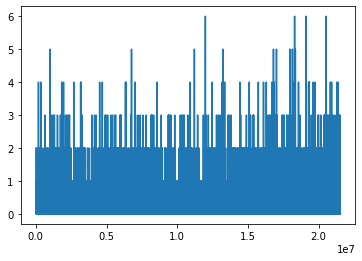

In [53]:
print(sales.shape)
print(sales.loc[sales['item_id'] == 1437].loc[:, 'demand'].shape)
print(sales.loc[sales['item_id'] == 1437].loc[sales['d'] == 1208].loc[:, 'demand'].shape)
plt.plot(sales.loc[sales['item_id'] == 1437].loc[:, 'demand'])
plt.show()

In [54]:
test = sales[sales.d >= 1914]
print(test.head())
print(test.id)

                          id  item_id  dept_id  cat_id  store_id  state_id  \
21525940  HOBBIES_1_001_CA_1     1437        3       1         0         0   
21525941  HOBBIES_1_002_CA_1     1438        3       1         0         0   
21525942  HOBBIES_1_003_CA_1     1439        3       1         0         0   
21525943  HOBBIES_1_004_CA_1     1440        3       1         0         0   
21525944  HOBBIES_1_005_CA_1     1441        3       1         0         0   

             d  demand  lag_t28  rolling_mean_t7  ...  event_type_1  \
21525940  1914     NaN      1.0         1.142578  ...             4   
21525941  1914     NaN      1.0         0.714355  ...             4   
21525942  1914     NaN      0.0         0.285645  ...             4   
21525943  1914     NaN      0.0         3.000000  ...             4   
21525944  1914     NaN      1.0         0.714355  ...             4   

          event_name_2  event_type_2  snap_CA  snap_TX  snap_WI  sell_price  \
21525940             4   

In [55]:
test = sales[sales.d >= 1914]
print(test.head())
test = test.assign(id=test.id + "_" + np.where(test.d <= 1941, "validation", "evaluation"), F="F" + (test.d - 1913 - 28 * (test.d > 1941)).astype("str"))
print(test.head())
gc.collect()

# Input dict for training with a dense array and separate inputs for each embedding input
def make_X(df):
    X = {"dense1": df[dense_cols].to_numpy()}
    for i, v in enumerate(cat_cols):
        X[v] = df[[v]].to_numpy()
    return X

# Submission data
X_test = make_X(test)

# One month of validation data
flag = (sales.d < 1914) & (sales.d >= 1914 - 28)
valid = (make_X(sales[flag]),
         sales["demand"][flag])

# Rest is used for training
flag = sales.d < 1914 - 28
X_train = make_X(sales[flag])
y_train = sales["demand"][flag]
                             


                          id  item_id  dept_id  cat_id  store_id  state_id  \
21525940  HOBBIES_1_001_CA_1     1437        3       1         0         0   
21525941  HOBBIES_1_002_CA_1     1438        3       1         0         0   
21525942  HOBBIES_1_003_CA_1     1439        3       1         0         0   
21525943  HOBBIES_1_004_CA_1     1440        3       1         0         0   
21525944  HOBBIES_1_005_CA_1     1441        3       1         0         0   

             d  demand  lag_t28  rolling_mean_t7  ...  event_type_1  \
21525940  1914     NaN      1.0         1.142578  ...             4   
21525941  1914     NaN      1.0         0.714355  ...             4   
21525942  1914     NaN      0.0         0.285645  ...             4   
21525943  1914     NaN      0.0         3.000000  ...             4   
21525944  1914     NaN      1.0         0.714355  ...             4   

          event_name_2  event_type_2  snap_CA  snap_TX  snap_WI  sell_price  \
21525940             4   

In [56]:
del sales, flag
gc.collect()

20

In [57]:
print(test['id'])
test = test.replace('validation_validation', '_validation')
print(test.head())

21525940    HOBBIES_1_001_CA_1_validation
21525941    HOBBIES_1_002_CA_1_validation
21525942    HOBBIES_1_003_CA_1_validation
21525943    HOBBIES_1_004_CA_1_validation
21525944    HOBBIES_1_005_CA_1_validation
                        ...              
23233375      FOODS_3_823_WI_3_evaluation
23233376      FOODS_3_824_WI_3_evaluation
23233377      FOODS_3_825_WI_3_evaluation
23233378      FOODS_3_826_WI_3_evaluation
23233379      FOODS_3_827_WI_3_evaluation
Name: id, Length: 1707440, dtype: object
                                     id  item_id  dept_id  cat_id  store_id  \
21525940  HOBBIES_1_001_CA_1_validation     1437        3       1         0   
21525941  HOBBIES_1_002_CA_1_validation     1438        3       1         0   
21525942  HOBBIES_1_003_CA_1_validation     1439        3       1         0   
21525943  HOBBIES_1_004_CA_1_validation     1440        3       1         0   
21525944  HOBBIES_1_005_CA_1_validation     1441        3       1         0   

          state_id    

In [58]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Input, Embedding, Dropout, concatenate, Flatten
from tensorflow.keras.models import Model

In [59]:
def create_model(lr=0.002):
    tf.random.set_seed(173)

    tf.keras.backend.clear_session()
    gc.collect()

    # Dense input
    dense_input = Input(shape=(len(dense_cols), ), name='dense1')

    # Embedding input
    wday_input = Input(shape=(1,), name='wday')
    month_input = Input(shape=(1,), name='month')
    year_input = Input(shape=(1,), name='year')
    event_name_1_input = Input(shape=(1,), name='event_name_1')
    event_type_1_input = Input(shape=(1,), name='event_type_1')
    event_name_2_input = Input(shape=(1,), name='event_name_2')
    event_type_2_input = Input(shape=(1,), name='event_type_2')
    item_id_input = Input(shape=(1,), name='item_id')
    dept_id_input = Input(shape=(1,), name='dept_id')
    store_id_input = Input(shape=(1,), name='store_id')
    cat_id_input = Input(shape=(1,), name='cat_id')
    state_id_input = Input(shape=(1,), name='state_id')

    wday_emb = Flatten()(Embedding(7, 1)(wday_input))
    month_emb = Flatten()(Embedding(12, 1)(month_input))
    year_emb = Flatten()(Embedding(6, 1)(year_input))
    event_name_1_emb = Flatten()(Embedding(31, 1)(event_name_1_input))
    event_type_1_emb = Flatten()(Embedding(5, 1)(event_type_1_input))
    event_name_2_emb = Flatten()(Embedding(5, 1)(event_name_2_input))
    event_type_2_emb = Flatten()(Embedding(5, 1)(event_type_2_input))

    item_id_emb = Flatten()(Embedding(3049, 3)(item_id_input))
    dept_id_emb = Flatten()(Embedding(7, 1)(dept_id_input))
    store_id_emb = Flatten()(Embedding(10, 1)(store_id_input))
    cat_id_emb = Flatten()(Embedding(3, 1)(cat_id_input))
    state_id_emb = Flatten()(Embedding(3, 1)(state_id_input))

    # Combine dense and embedding parts and add dense layers. Exit on linear scale.
    x = concatenate([dense_input, wday_emb, month_emb, year_emb, 
                     event_name_1_emb, event_type_1_emb, 
                     event_name_2_emb, event_type_2_emb, 
                     item_id_emb, dept_id_emb, store_id_emb,
                     cat_id_emb, state_id_emb])
    x = Dense(150, activation="tanh")(x)
    x = Dense(75, activation="tanh")(x)
    x = Dense(10, activation="tanh")(x)
    outputs = Dense(1, activation="linear", name='output')(x)

    inputs = {"dense1": dense_input, "wday": wday_input, "month": month_input, "year": year_input, 
              "event_name_1": event_name_1_input, "event_type_1": event_type_1_input,
              "event_name_2": event_name_2_input, "event_type_2": event_type_2_input,
              "item_id": item_id_input, "dept_id": dept_id_input, "store_id": store_id_input, 
              "cat_id": cat_id_input, "state_id": state_id_input}

    # Connect input and output
    model = Model(inputs, outputs)

    model.compile(loss=keras.losses.mean_squared_error,
                  metrics=["mse"],
                  optimizer=keras.optimizers.RMSprop(learning_rate=lr))
    return model

In [60]:
model = create_model(0.0002)
model.summary()
keras.utils.plot_model(model, 'model.png', show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
wday (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
month (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
year (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
event_name_1 (InputLayer)       [(None, 1)]          0                                            
______________________________________________________________________________________________

In [61]:
history = model.fit(X_train, 
                    y_train,
                    batch_size=10000,
                    epochs=30,
                    shuffle=True,
                    validation_data=valid)

Train on 20672220 samples, validate on 853720 samples
Epoch 1/30
20672220/20672220 [==============================] - 19s 1us/sample - loss: 9.5783 - mse: 9.5783 - val_loss: 8.3335 - val_mse: 8.3335
Epoch 2/30
20672220/20672220 [==============================] - 15s 1us/sample - loss: 8.1726 - mse: 8.1726 - val_loss: 7.2395 - val_mse: 7.2395
Epoch 3/30
20672220/20672220 [==============================] - 15s 1us/sample - loss: 7.4242 - mse: 7.4242 - val_loss: 6.5976 - val_mse: 6.5976
Epoch 4/30
20672220/20672220 [==============================] - 15s 1us/sample - loss: 6.9629 - mse: 6.9629 - val_loss: 6.2101 - val_mse: 6.2101
Epoch 5/30
20672220/20672220 [==============================] - 15s 1us/sample - loss: 6.6519 - mse: 6.6519 - val_loss: 5.9546 - val_mse: 5.9546
Epoch 6/30
20672220/20672220 [==============================] - 15s 1us/sample - loss: 6.4329 - mse: 6.4329 - val_loss: 5.7889 - val_mse: 5.7889
Epoch 7/30
20672220/20672220 [==============================] - 15s 1us/samp

In [62]:
model.save('model.h5')
pred = model.predict(X_test, batch_size=10000)
print(pred.clip(0))

[[0.79952073]
 [0.35318494]
 [0.36132693]
 ...
 [0.5067823 ]
 [0.52480197]
 [0.61224055]]


In [63]:
test["demand"] = pred.clip(0)
print(test.head())
print(sample_submission.head())
submission = test.pivot(index="id", columns="F", values="demand").reset_index()[sample_submission.columns]
print(submission.head())
submission = sample_submission[["id"]].merge(submission, how="left", on="id")
submission.head()

                                     id  item_id  dept_id  cat_id  store_id  \
21525940  HOBBIES_1_001_CA_1_validation     1437        3       1         0   
21525941  HOBBIES_1_002_CA_1_validation     1438        3       1         0   
21525942  HOBBIES_1_003_CA_1_validation     1439        3       1         0   
21525943  HOBBIES_1_004_CA_1_validation     1440        3       1         0   
21525944  HOBBIES_1_005_CA_1_validation     1441        3       1         0   

          state_id     d    demand  lag_t28  rolling_mean_t7  ...  \
21525940         0  1914  0.799521      1.0         1.142578  ...   
21525941         0  1914  0.353185      1.0         0.714355  ...   
21525942         0  1914  0.361327      0.0         0.285645  ...   
21525943         0  1914  1.822685      0.0         3.000000  ...   
21525944         0  1914  1.029083      1.0         0.714355  ...   

          event_name_2  event_type_2  snap_CA  snap_TX  snap_WI  sell_price  \
21525940             4         

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.799521,0.722283,0.711193,0.715965,0.788292,0.938486,1.019942,0.733530,0.794883,...,0.894637,1.156605,1.036239,0.841722,0.779363,0.773236,0.854146,0.875015,1.084699,1.127509
1,HOBBIES_1_002_CA_1_validation,0.353185,0.346343,0.343862,0.333164,0.339472,0.373811,0.390815,0.263693,0.249213,...,0.245566,0.272589,0.277838,0.198686,0.184870,0.209351,0.221625,0.241184,0.279729,0.273229
2,HOBBIES_1_003_CA_1_validation,0.361327,0.342741,0.341306,0.348441,0.361520,0.426885,0.522835,0.311776,0.276475,...,0.372334,0.461366,0.508799,0.459521,0.475834,0.482491,0.444408,0.480465,0.577956,0.577576
3,HOBBIES_1_004_CA_1_validation,1.822685,1.615085,1.565795,1.554664,1.920845,2.211947,2.406686,1.667011,1.694355,...,1.928290,2.131809,2.479370,1.945610,1.719952,1.580849,1.667029,1.965351,2.653845,2.511599
4,HOBBIES_1_005_CA_1_validation,1.029083,0.892050,1.053616,1.178324,1.177223,1.532969,2.021184,1.286205,1.323280,...,1.299508,1.485227,1.506141,1.040770,1.006258,0.988770,1.056295,1.210055,1.567927,1.827667


In [64]:
submission.to_csv("submission.csv", index=False)

In [66]:
test.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28,rolling_mean_t7,...,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,sell_price_rel_diff,sell_price_roll_sd7,sell_price_cumrel,F
21525940,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,1914,0.799521,1.0,1.142578,...,4,2,0,0,0,8.382812,0.0,0.064148,0.051727,F1
21525941,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,1914,0.353185,1.0,0.714355,...,4,2,0,0,0,3.970703,0.0,0.000000,0.000000,F1
21525942,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,1914,0.361327,0.0,0.285645,...,4,2,0,0,0,2.970703,0.0,0.000000,0.000000,F1
21525943,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,1914,1.822685,0.0,3.000000,...,4,2,0,0,0,4.640625,0.0,0.000000,0.230713,F1
21525944,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,1914,1.029083,1.0,0.714355,...,4,2,0,0,0,2.880859,0.0,0.000000,0.250000,F1


In [74]:
for x in X_train:
    print(x)
    print(X_train[x].shape)

dense1
(20672220, 15)
item_id
(20672220, 1)
dept_id
(20672220, 1)
store_id
(20672220, 1)
cat_id
(20672220, 1)
state_id
(20672220, 1)
wday
(20672220, 1)
month
(20672220, 1)
year
(20672220, 1)
event_name_1
(20672220, 1)
event_type_1
(20672220, 1)
event_name_2
(20672220, 1)
event_type_2
(20672220, 1)


In [15]:
# Plots for CA
data_divisions = {
    'state_id': ['CA', 'TX', 'WI'],
    'store_id': [['CA_1', 'CA_2', 'CA_3', 'CA_4'], ['TX_1', 'TX_2', 'TX_3'], ['WI_1', 'WI_2', 'WI_3']],
    'cat_id': ['HOBBIES', 'HOUSEHOLD', 'FOODS'],
    'dept_id': [['HOBBIES_1', 'HOBBIES_2'], ['HOUSEHOLD_1', 'HOUSEHOLD_2'], ['FOODS_1', 'FOODS_2', 'FOODS_3']]
}

# store sum series will store the sum of all items in a specific department i.e 'HOBBIES_1' in the form: 
# store_sum_series[store, deptartment], where each entry is a 1D time series of sales across the whole department
# Each time series can be formatted into LSTM friendly formats and input to neural network for training
# Intial training/validation split could take entries from 8/10 stores for training and remaining 2 for val?

store_series = [] 
store_sum_series = []
store_ids = []
depart_ids = []

for state in data_divisions['store_id']:
    for store in state:
        time_series = []
        sum_series = []
        store_ids_state = []
        for dept in data_divisions['dept_id']:
            for item in dept:
                entry = df.loc[df['store_id'] == str(store)].loc[df['dept_id'] == str(item)].iloc[:, d1_col:d1_col+n_days]
                time_series.append(entry)
                sum_series.append(np.sum(entry, axis=0))
                store_ids_state.append(str(store))
                depart_ids.append(str(item))
        store_series.append(time_series)
        store_sum_series.append(sum_series)
        store_ids.append(store_ids_state)

NameError: name 'df' is not defined

In [10]:
print(len(store_series))
print(len(store_sum_series))
print(len(store_ids))
print(len(depart_ids))
print(len(store_series[0]))
print(len(store_sum_series[0]))
print(len(store_ids[0]))
print(depart_ids[0])


10
10
10
70
7
7
7
HOBBIES_1


In [ ]:
from numpy import array

n_steps = 30

X_LSTM = np.empty((0, n_steps))
X_emb = np.empty((0, n_steps))
targets = np.empty((0, 1))

for i in range(len(store_sum_series) - 1):
    input_sequence = store_sum_series[i][0]
    X_tmp, y_tmp = split_sequence(input_sequence, n_steps)
    X_emb_tmp, y_emb_tmp = split_sequence(0.5 * np.ones(input_sequence.shape), n_steps)
    X_LSTM = np.concatenate((X_LSTM, X_tmp), axis=0)
    y_tmp = np.reshape(y_tmp, (y_tmp.shape[0], 1))
    X_emb = np.concatenate((X_emb, X_emb_tmp), axis=0)
    targets = np.concatenate((targets, y_tmp), axis=0)
    print(X_LSTM.shape)
    print(targets.shape)
    
input_shape = store_sum_series[len(store_sum_series)-1][0].shape

X_LSTM_val, targets_val = split_sequence(store_sum_series[len(store_sum_series)-1][0], n_steps)
targets_val = np.reshape(targets_val, (targets_val.shape[0], 1))
X_emb_val, y_emb_val = split_sequence(0.5 * np.ones(input_shape), n_steps)

X_LSTM = np.reshape(X_LSTM, (X_LSTM.shape[0], X_LSTM.shape[1], 1))
X_LSTM_val = np.reshape(X_LSTM_val, (X_LSTM_val.shape[0], X_LSTM_val.shape[1], 1))
X_emb = np.reshape(X_emb, (X_emb.shape[0], X_emb.shape[1], 1))
X_emb_val = np.reshape(X_emb_val, (X_emb_val.shape[0], X_emb_val.shape[1], 1))

print(X_LSTM.shape)
print(targets.shape)
print(X_emb.shape)
print(X_LSTM_val.shape)
print(targets_val.shape)
print(X_emb_val.shape)